# Image Caption Generator

This project is an analysis of some images where the deep learning models recognize the context of the images and describe them in natural language - English here.

The image folders are loaded from drive and unziped for the analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/Image_Dataset1.zip" -d Image_Dataset1

Streaming output truncated to the last 5000 lines.
  inflating: Image_Dataset1/2844747252_64567cf14a.jpg  
  inflating: Image_Dataset1/2844846111_8c1cbfc75d.jpg  
  inflating: Image_Dataset1/2844963839_ff09cdb81f.jpg  
  inflating: Image_Dataset1/2845246160_d0d1bbd6f0.jpg  
  inflating: Image_Dataset1/2845691057_d4ab89d889.jpg  
  inflating: Image_Dataset1/2845845721_d0bc113ff7.jpg  
  inflating: Image_Dataset1/2846037553_1a1de50709.jpg  
  inflating: Image_Dataset1/2846785268_904c5fcf9f.jpg  
  inflating: Image_Dataset1/2846843520_b0e6211478.jpg  
  inflating: Image_Dataset1/2847514745_9a35493023.jpg  
  inflating: Image_Dataset1/2847615962_c330bded6e.jpg  
  inflating: Image_Dataset1/2847859796_4d9cb0d31f.jpg  
  inflating: Image_Dataset1/2848266893_9693c66275.jpg  
  inflating: Image_Dataset1/2848571082_26454cb981.jpg  
  inflating: Image_Dataset1/2848895544_6d06210e9d.jpg  
  inflating: Image_Dataset1/2848977044_446a31d86e.jpg  
  inflating: Image_Dataset1/2849194983_2968c72832.jpg

In [ ]:
!unzip "/content/gdrive/My Drive/Image_Dataset2.zip" -d Image_Dataset2

Archive:  /content/gdrive/My Drive/Image_Dataset2.zip
  inflating: Image_Dataset2/10033.jpg  
  inflating: Image_Dataset2/10061.jpg  
  inflating: Image_Dataset2/10063.jpg  
  inflating: Image_Dataset2/10081.jpg  
  inflating: Image_Dataset2/10085.jpg  
  inflating: Image_Dataset2/10100.jpg  
  inflating: Image_Dataset2/10116.jpg  
  inflating: Image_Dataset2/10141.jpg  
  inflating: Image_Dataset2/10142.jpg  
  inflating: Image_Dataset2/10146.jpg  
  inflating: Image_Dataset2/10204.jpg  
  inflating: Image_Dataset2/10205.jpg  
  inflating: Image_Dataset2/10209.jpg  
  inflating: Image_Dataset2/10215.jpg  
  inflating: Image_Dataset2/10216.jpg  
  inflating: Image_Dataset2/10221.jpg  
  inflating: Image_Dataset2/10222.jpg  
  inflating: Image_Dataset2/10240.jpg  
  inflating: Image_Dataset2/10241.jpg  
  inflating: Image_Dataset2/10244.jpg  
  inflating: Image_Dataset2/10245.jpg  
  inflating: Image_Dataset2/10246.jpg  
  inflating: Image_Dataset2/10247.jpg  
  inflating: Image_Dataset

All the libraries needed are imported as follows.

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from transformers import BlipForConditionalGeneration, AutoProcessor
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

## Data Collection

The data used in this analysis consists of two datasets -
1. Flickr8k dataset
2. IAPRTC12 dataset

## Data Preprocessing

The captions of these two datasets are stored in two separate files. The captions are loaded and these are stored in a dictionary with image name as key and captions as value in the form of any array. These are later cleaned to remove noise in the captions.

### Load captions data

In [2]:
# Reading the captions file
with open('/content/gdrive/My Drive/captions_Dataset1.txt', 'r') as file:
    captions_dataset1 = file.readlines()

with open('/content/gdrive/My Drive/captions_Dataset2.txt', 'r') as file:
    captions_dataset2 = file.readlines()

In [3]:
# Mapping the image and captions into a dictionary
mapping = {}

# Dataset1
for line in captions_dataset1[1:]:
    tokens = line.split(',')
    key = tokens[0]
    caption = tokens[1]
    if key not in mapping:
        mapping[key] = []
    mapping[key].append(caption)

# Dataset2
for line in captions_dataset2[1:]:
    tokens = line.split(';')
    key = tokens[0]
    caption = tokens[1]
    if key not in mapping:
        mapping[key] = []
    mapping[key].append(caption)

print("Total number of images: " + str(len(mapping)))

Total number of images: 12800


### Cleaning the captions

The captions are cleaned such that irrelevant characters such as digits, special characters are removed. Also, extra spaces are trimmed. The case of all captions are made lower.

In [4]:
# Converting the case and replacing irrelevant characters
for image, captions in mapping.items():
    for i in range(len(captions)):
        cleaned_caption = captions[i].lower().replace('[^A-Za-z]', '').replace('\s+', ' ')
        processed_caption = 'startseq ' + " ".join([word for word in cleaned_caption.split() if len(word)>1]) + ' endseq'
        captions[i] = processed_caption

In [5]:
# Storing all the possible captions into a list for tokenization
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

print("Total number of possible captions: " + str(len(all_captions)))

Total number of possible captions: 48899


In [6]:
# Processed captions after cleaning
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

The analysis is performed using two approaches and are compared to see which approach would be a better choice for image captioning task. The two approaches used here are:

1. CNN and LSTM
2. Transformer model

## CNN and LSTM

In this approach, the processed captions are first tokenized. Further, the features of images are extracted. Once the captions and images are ready, the model is trained and evaluated.

### Tokenize the captions

The captions are tokenized such that the captions are broken down into smaller units for analysis. Further, the maximum caption length is identified which will be used as reference of padding sequence.

In [7]:
# Tokenizing all the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

print("Total number of words in the vocabulary: " + str(vocab_size))

Total number of words in the vocabulary: 8832


In [8]:
# Getting the maximum length of the longest caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

48

### Extraction of Image features

The features of the images are extracted using pre-trained model. The features extracted are used for training.

In [11]:
# Loading the pre-trained VGG16 model to extract features from images
# Create the full VGG16 model. This includes prediction layer
base_model = VGG16()

# Extract the desired layers up to the one before prediction layer
model = Model(inputs = base_model.inputs , outputs = base_model.layers[-2].output)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [13]:
# Extracting features from two datasets
features = {}
dataset1_path = '/content/Image_Dataset1'
dataset2_path = '/content/Image_Dataset2'

# Dataset 1
for img_name in tqdm(os.listdir(dataset1_path)):
    # Loading the images with size 224 * 224
    img_path = dataset1_path + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # Converting the image to numpy array
    image = img_to_array(image)
    # The data is reshaped for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # The image loaded is processed so that it is suitable for VGG16 prediction
    image = preprocess_input(image)
    # Extracting the features from the model
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    # Storing the feature such that value is the feature predicted and the image name is the key
    features[image_id] = feature

# Dataset 2
for img_name in tqdm(os.listdir(dataset2_path)):
    # Loading the images with size 224 * 224
    img_path = dataset2_path + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # Converting the image to numpy array
    image = img_to_array(image)
    # The data is reshaped for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # The image loaded is processed so that it is suitable for VGG16 prediction
    image = preprocess_input(image)
    # Extracting the features from the model
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    # Storing the feature such that value is the feature predicted and the image name is the key
    features[image_id] = feature

print("Total length of the features dictionary after extraction: " + str(len(features)))

100%|██████████| 4709/4709 [07:24<00:00, 10.58it/s]

Total length of the features dictionary after extraction: 12800


In [14]:
# Storing extracted features in pickle file
with open('features.pkl', 'wb') as file:
    pickle.dump(features, file)

The features are stored in a pickle file as above so that it can be re-used without re-running extraction of features again and again.

In [15]:
# Loading the extracted features from pickle file
with open('features.pkl', 'rb') as file:
    extracted_features = pickle.load(file)

In [16]:
len(extracted_features)

12800

In [17]:
# Shape of each extracted feature
first_array = next(iter(extracted_features.values()))
print(first_array.shape)

(1, 4096)


### Creation of train and test data

The dataset is divided into training and test data with 90% of the total dataset as training data and remaining 10% is used as test data. The data is sampled, so that the two datasets are shuffled and training and test sets have data from both the datasets.

In [18]:
import random

# Sampling the image ids from the dictionary
mapping_ids = [id.split('.')[0] for id in mapping.keys()]
image_ids = random.sample(mapping_ids, len(mapping_ids))
# Split value such that 90% is used for training
split = int(len(image_ids) * 0.9)
train_ids = image_ids[:split]
test_ids = image_ids[split:]

print("Number of training images: " + str(len(train_ids)))
print("Number of test images: " + str(len(test_ids)))

Number of training images: 11520
Number of test images: 1280


A batch is created and padding sequence is included. This will be helpful to normalize the size of captions to the maximum length by filling them with zeros.

In [19]:
# Data generator is created to get the data in a batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key+".jpg"]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation

The model consists of encoder-decoder architecture for sequence-to-sequence tasks.

The encoder processes images and captions separately, and the decoder combines the encoded representations obtained from encoder and tries to predict the next word in the sequence.

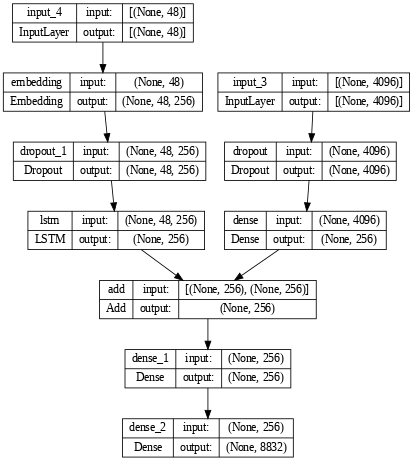

In [20]:
# Encoder model

# Input layer 1 for images
inputs1 = Input(shape=(4096,))
# Dropout layer
fe1 = Dropout(0.4)(inputs1)
# Dense layer to transform image features to lower dimension
fe2 = Dense(256, activation='relu')(fe1)

# Input layer 2 for captions
inputs2 = Input(shape=(max_length,))
# Embedding layer to map each integer representing a word in the vocabulary
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# Dropout layer
se2 = Dropout(0.4)(se1)
# LSTM layer
se3 = LSTM(256)(se2)

# Decoder model

# Combination of both input layers from images and captions
decoder1 = add([fe2, se3])
# Dense layer to add activation unit for concatenated features
decoder2 = Dense(256, activation='relu')(decoder1)
# Output layer
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Defining the model with two input layers and one output layer
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plotting the model
plot_model(model, show_shapes=True, dpi=60)

 ### Model training

In [21]:
# train the model
epochs = 20
batch_size = 32
steps = len(train_ids) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_ids, mapping, extracted_features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

360/360 [==============================] - 117s 325ms/step - loss: 2.0133


In [22]:
# Saving the model to a file so that it can be re-used without training the model again and again
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model.save('keras_model.keras')

It can be observed that the loss is reduced gradually as the number of epochs increase. This means that as the difference between actual and expected values is reduced during the training process.

### Model validation

The output from the model is an index which corresponds to some word. The following functions are used to predict captions in the form of indices.

The model keeps returning index of possible next word. By Combining each word returned, caption is generated.

In [24]:
# Converting index to word using tokenizer
def index_to_word(returned_index, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == returned_index:
            return word
    return None

In [25]:
# Predicting captions using the model created

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    # Iterating over maximum possible length of captions
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Padding the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predicting next word using the model
        next_word = model.predict([image, sequence], verbose=0)
        # Selecting the index with highest probability
        next_word = np.argmax(next_word)
        # Converting the index to word
        predicted_word = index_to_word(next_word, tokenizer)
        # If word is not found then stop
        if predicted_word is None:
            break
        # Combining each word
        in_text += " " + predicted_word
        # Stop the loop when end is reached
        if predicted_word == 'endseq':
            break
    return in_text

BLEU score is used to evaluate the predicted text against a reference text for this model in a form of tokens. The reference text contains all the words from captions.

In [26]:
# Calculating the model score
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()
for key in tqdm(test_ids):
    # Actual captions
    captions = mapping[key+'.jpg']
    # Predicted caption
    y_pred = predict_caption(model, extracted_features[key], tokenizer, max_length)
    # Corpus of actual and predicted captions are created
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

# Score based on the actual and predicted captions
print("BLEU score: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

100%|██████████| 1280/1280 [18:57<00:00,  1.13it/s]


BLEU score: 0.528218


Reference for using BLEU score: https://www.traceloop.com/blog/demystifying-the-bleu-metric

According to this page, the score above 0.3 is good result. Therefore, we can say that the model is performing with good results.

### Some sample results

The following function can be used to predict the caption and display the results.

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to generate the caption for given image name
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = '/content/Image_Dataset2/' + image_name
    image = Image.open(img_path)
    captions = mapping[image_id+".jpg"]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # Predicting the caption
    y_pred = predict_caption(model, extracted_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq sunset behind clouds over the sea endseq
startseq breaking and broken wave in the foreground endseq
--------------------Predicted--------------------
startseq the dark outlines of mountain range and clouds in the background endseq


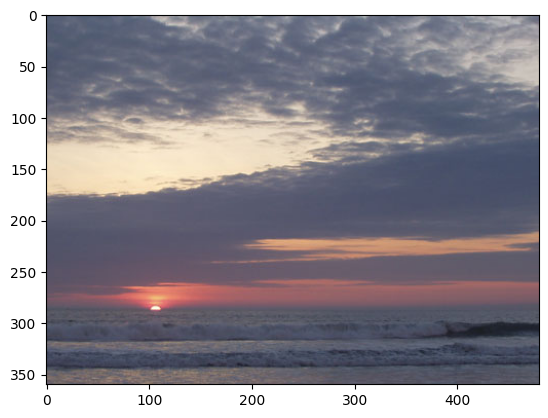

In [30]:
generate_caption('10615.jpg')

---------------------Actual---------------------
startseq blue lake in the middle of brown desert landscape with hills endseq
--------------------Predicted--------------------
startseq brown mountains and blue sky in the background endseq


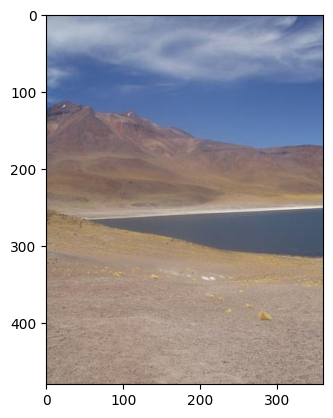

In [31]:
generate_caption('9086.jpg')

---------------------Actual---------------------
startseq waterfall and river with brown rocks on the bank in the middle of green jungle endseq
startseq blue sky in the background endseq
--------------------Predicted--------------------
startseq view of bay with many small brown rocks and many small rocks endseq


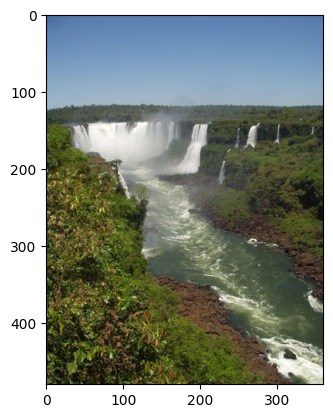

In [33]:
generate_caption('17917.jpg')

It is observed that the captions generated are close to the description of the scenic images.

Therefore, it can be concluded that the model created can be used to generate captions for scenic images.

## Transformers

The model from HuggingFace that is pre-trained is used and fine-tuned with our datasets containing scenic images. For this approach, the images need to be passed in a certain format. This is done by creating a custom class for images. Further, the pre-trained models are loaded and trained with the custom dataset created and later evaluated.

### Creation of custom dataset

The dataset being used needs to be in a format that is accepted by transformer. The following class helps in performing the task.

In [34]:
# Class representing the image captioning dataset
class ImageCaptionDataset(Dataset):
    def __init__(self, data_path, captions, processor, transform=None, train_ids=None, test_ids=None):
        self.data_path = data_path
        self.captions = captions
        self.transform = transform
        self.processor = processor
        # Filter data based on IDs (if provided)
        self.image_paths = []
        if train_ids:
            self.image_paths.extend([path for path in train_ids])
        if test_ids:
            self.image_paths.extend([path for path in test_ids])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        captions = [caption.replace('startseq','').replace('endseq', '') for caption in self.captions[image_path]]
        caption = " ".join(captions)
        # If the image length is less than 9, it belongs to scenic dataset
        if len(image_path) <= 9:
            image_path = 'Image_Dataset2/' + image_path
        else:
            image_path = 'Image_Dataset1/' + image_path
        image = Image.open(os.path.join(self.data_path, image_path)).convert('RGB')
        # Transforming the image based on transformer requirements
        if self.transform:
            image = self.transform(image)
        encoding = self.processor(images=image, text=caption, padding='max_length', truncation=True, return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

The images need to be resized to ensure consistency and for better results.

In [35]:
# Transformation object that transforms and normalizes the images as needed by transformer
transform = transforms.Compose([
    transforms.Resize(size=(224, 224))
])

### Loading pre-trained model

The processor to encode the images and pre-trained model is loaded. The model being used is "BLIP" which is widely used for image captioning tasks.

In [36]:
dir = 'Cache'
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base", cache_dir=dir)
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", cache_dir=dir)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

### Creation of training and test dataset

In [61]:
# Creating the custom dataset object based on training and test ids found earlier
train_ids = [id + '.jpg' if '.jpg' not in id else id for id in train_ids]
test_ids = [id + '.jpg' if '.jpg' not in id else id for id in test_ids]
train_dataset = ImageCaptionDataset('/content/', mapping, processor, transform, train_ids=train_ids)
test_dataset = ImageCaptionDataset('/content/', mapping, processor, transform, test_ids=test_ids)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

### Model training

In [40]:
model.train()

num_epochs = 2
for epoch in range(num_epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_loader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    attention_mask = batch.pop("attention_mask").to(device)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    del input_ids, pixel_values, outputs, loss  # Free up memory

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.825170516967773
Loss: 9.799870491027832
Loss: 9.432672500610352
Loss: 8.898442268371582
Loss: 8.631999015808105
Loss: 8.185626029968262
Loss: 8.02638053894043
Loss: 7.713170051574707
Loss: 7.432495594024658
Loss: 7.110246181488037
Loss: 7.003768444061279
Loss: 6.781641006469727
Loss: 6.392483234405518
Loss: 6.332292079925537
Loss: 6.118057727813721
Loss: 5.817521095275879
Loss: 5.558243274688721
Loss: 5.582176208496094
Loss: 5.106210708618164
Loss: 4.943533897399902
Loss: 4.698525905609131
Loss: 4.5232834815979
Loss: 4.272681713104248
Loss: 3.931468963623047
Loss: 3.7157158851623535
Loss: 3.5164482593536377
Loss: 3.190668821334839
Loss: 2.9230103492736816
Loss: 2.7596240043640137
Loss: 2.491405725479126
Loss: 2.410098075866699
Loss: 2.0560505390167236
Loss: 1.954016089439392
Loss: 1.5833618640899658
Loss: 1.392557978630066
Loss: 1.33837890625
Loss: 1.0633221864700317
Loss: 0.9918091893196106
Loss: 1.0012584924697876
Loss: 0.6597048044204712
Loss: 0.7506954073905945
Loss: 0.644

It is observed that lesser epochs compared to CNN and LSTM model have provided better results - lesser loss.

### Model validation

In [77]:
actual, predicted = list(), list()
for key in test_ids:
    # Actual captions
    captions = mapping[key]
    # Predicted caption
    if len(key) <= 9:
      img_path = '/content/Image_Dataset2/' + key
    else:
      img_path = '/content/Image_Dataset1/' + key
    image = Image.open(img_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=20)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    # Corpus of actual and predicted captions are created
    actual_captions = [caption.split() for caption in captions]
    generated_caption = generated_caption.split()
    actual.append(actual_captions)
    predicted.append(generated_caption)

# Score based on the actual and predicted captions
print("BLEU score: ", corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

BLEU score:  0.6512605042016807


It is observed that BLEU score for our trained transformer model is better compared to CNN and LSTM model.

### Some sample results

In [53]:
# Function to generate the caption for given image name
def generate_caption_transformer(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = '/content/Image_Dataset2/' + image_name
    captions = mapping[image_id+".jpg"]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # Predicting the caption
    image = Image.open(img_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=20)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print('---------------------Predicted---------------------')
    print(generated_caption)
    plt.imshow(image)

---------------------Actual---------------------
startseq sunset behind clouds over the sea endseq
startseq breaking and broken wave in the foreground endseq
---------------------Predicted---------------------
the sun is rising over the horizon of the sea and sky in the background


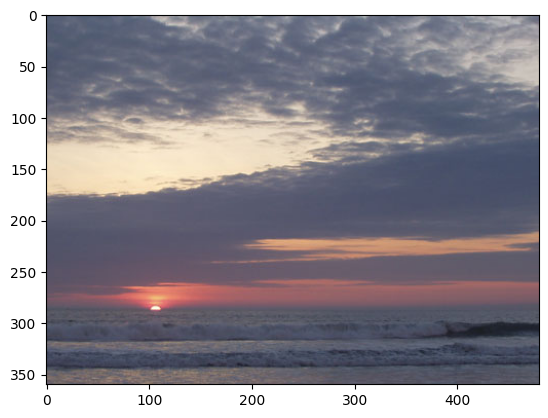

In [56]:
generate_caption_transformer('10615.jpg')

---------------------Actual---------------------
startseq blue lake in the middle of brown desert landscape with hills endseq
---------------------Predicted---------------------
grey lake in the desert with brown mountain behind it


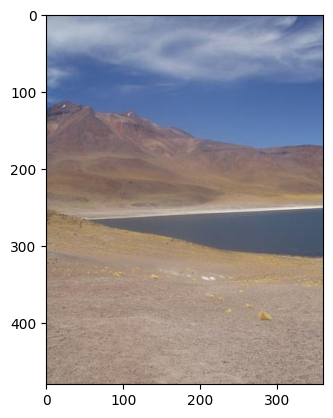

In [54]:
generate_caption_transformer('9086.jpg')

---------------------Actual---------------------
startseq waterfall and river with brown rocks on the bank in the middle of green jungle endseq
startseq blue sky in the background endseq
---------------------Predicted---------------------
grey waterfall in the middle of green field with few bushes and bushes in the background


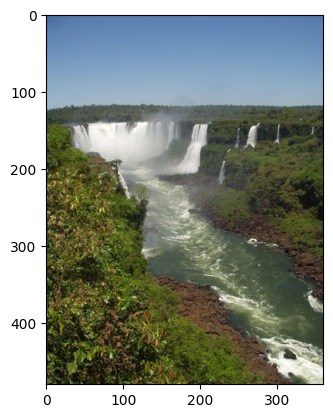

In [55]:
generate_caption_transformer('17917.jpg')

## Conclusion

In conclusion, this analysis has compared the performed of CNN, LSTM and transformer models for image captioning task has yielded valuable insights.

The transformer models have performed better as evidenced by significantly higher BLEU scores. It is also observed that the captions generated by transformer model is more informative compared to CNN and LSTM model.

Therefore, we can conclude that the trained transformer models may be an effective approach to caption scenic images.